# Effective Graph Paper
Code to generate "BreastCancer" figure 

In [2]:
import numpy as np
import pandas as pd
from pandas import IndexSlice as idx
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import graphviz
import cana
from cana.boolean_network import BooleanNetwork
from cana.datasets.bio import BREAST_CANCER
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display, SVG
import networkx as nx
from collections import Counter
from copy import copy

In [3]:
def normalize(x, ab, db):
    return db[0] + (x - ab[0]) * (db[1] - db[0]) / (ab[1] - ab[0])

In [4]:
def _prox2dist(x):
    if x == 0:
        return np.inf
    else:
        return (1 / float(x)) - 1

def _dist2prox(x):
    if x == np.inf:
        return 0
    else:
        return (x + 1) ** -1

In [5]:
def calculates_path_length(G, path, weight='weight'):
    path_weight_sum = 0.0
    weakest_link = np.inf
    for source, target in zip(path[:-1], path[1:]):
        edge_weight = G.edges[(source, target)][weight]
        path_weight_sum += edge_weight
        if edge_weight < weakest_link:
            weakest_link = edge_weight
    return path_weight_sum, weakest_link

In [6]:
C = BREAST_CANCER()

In [7]:
SG = C.structural_graph()
EG = C.effective_graph(mode='input', bound='mean', threshold=-1)
#
EG0 = C.effective_graph(mode='input', bound='mean', threshold=0)
EG0p2 = C.effective_graph(mode='input', bound='mean', threshold=.2)
EG0p4 = C.effective_graph(mode='input', bound='mean', threshold=.4)

In [8]:
pd.options.display.float_format = '{:.2g}'.format
#
bound = 'upper'
df = pd.DataFrame({
        'node':[n.name for n in C.nodes],
        'k':[n.k for n in C.nodes],
        'k_r':[n.input_redundancy(mode='node', bound=bound, norm=False) for n in C.nodes],
        'k_e':[n.effective_connectivity(mode='node', bound=bound, norm=False) for n in C.nodes],
        'k_r*':[n.input_redundancy(mode='node', bound=bound, norm=True) for n in C.nodes],
        'k_e*':[n.effective_connectivity(mode='node', bound=bound, norm=True) for n in C.nodes],
        'k^{out}':[v for n,v in EG.out_degree()],
        'k_e^{out}':[v for n,v in EG.out_degree(weight='weight')],
    })
#df = df[['k','k_r','k_e','k_r*','k_e*','k^{out}','k_e^{out}']]
df['k_e^{out}/k^{out}'] = df['k_e^{out}'] / df['k^{out}']
df.sort_values('k',ascending=False,inplace=True)
#print(df.to_latex(escape=False))
#
drugs = [3, 4, 5, 6, 7, 8, 9]
dfd = df.loc[drugs, ['node', 'k^{out}', 'k_e^{out}', 'k_e^{out}/k^{out}']]
dfd.sort_values('k_e^{out}/k^{out}',ascending=False,inplace=True)
display(dfd)
print(dfd.to_latex(escape=False, index=False))


,node,k^{out},k_e^{out},k_e^{out}/k^{out}
8,Palbociclib,2,2,1
5,Everolimus,4,3.2,0.81
7,Ipatasertib,2,1.3,0.65
4,Alpelisib,3,1.9,0.64
3,Fulvestrant,3,1.8,0.6
9,Neratinib,3,1.6,0.54
6,Trametinib,3,1.5,0.49


\begin{tabular}{lrrr}
\toprule
        node &  k^{out} &  k_e^{out} &  k_e^{out}/k^{out} \\
\midrule
 Palbociclib &        2 &          2 &                  1 \\
  Everolimus &        4 &        3.2 &               0.81 \\
 Ipatasertib &        2 &        1.3 &               0.65 \\
   Alpelisib &        3 &        1.9 &               0.64 \\
 Fulvestrant &        3 &        1.8 &                0.6 \\
   Neratinib &        3 &        1.6 &               0.54 \\
  Trametinib &        3 &        1.5 &               0.49 \\
\bottomrule
\end{tabular}



In [9]:
def number_of_input_nodes(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if inputs == [] or inputs == [True]:
            count += 1
    return count
#
def number_of_nodes_with_self_loop(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if any(inputs):
            count += 1
    return count
#
def number_of_input_nodes_with_self_loop(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if inputs == [True]:
            count += 1
    return count

In [10]:
for G, graph in [(SG, 'IG'), (EG0, 'EG'), (EG0p2, 'EG (0.2)'), (EG0p4, 'EG (0.4)')]:
    n_nodes = G.number_of_nodes()
    print('{g:s}: Number of nodes: {n:d}'.format(g=graph, n=n_nodes))
    n_nodes_with_self_loop = number_of_nodes_with_self_loop(G)
    print('{g:s}: Number nodes with a self-loop: {n:d}'.format(g=graph, n=n_nodes_with_self_loop))
    n_input_nodes = number_of_input_nodes(G)
    print('{g:s}: Number of input nodes: {n:d}'.format(g=graph, n=n_input_nodes))
    n_input_nodes_with_self_loop = number_of_input_nodes_with_self_loop(G)
    print('{g:s}: Number of input nodes with self-loop: {n:d}'.format(g=graph, n=n_input_nodes_with_self_loop))
    print('--')

IG: Number of nodes: 80
IG: Number nodes with a self-loop: 23
IG: Number of input nodes: 18
IG: Number of input nodes with self-loop: 18
--
EG: Number of nodes: 80
EG: Number nodes with a self-loop: 23
EG: Number of input nodes: 18
EG: Number of input nodes with self-loop: 18
--
EG (0.2): Number of nodes: 80
EG (0.2): Number nodes with a self-loop: 22
EG (0.2): Number of input nodes: 21
EG (0.2): Number of input nodes with self-loop: 19
--
EG (0.4): Number of nodes: 80
EG (0.4): Number nodes with a self-loop: 22
EG (0.4): Number of input nodes: 29
EG (0.4): Number of input nodes with self-loop: 20
--


In [11]:
def weakly_connected_components(G):
    wcc = [len(cc) for cc in nx.weakly_connected_components(G)]
    return len(wcc), wcc
#
def strongly_connected_components(G):
    scc = [len(cc) for cc in nx.strongly_connected_components(G)]
    return len(scc), scc
#
def SortedCounter(l):
    c = dict(sorted(Counter(l).most_common(), reverse=True)) 
    return c

In [12]:
for G, graph in [(SG, 'IG'), (EG0, 'EG'), (EG0p2, 'EG (0.2)'), (EG0p4, 'EG (0.4)')]:
    n_wcc, wcc = weakly_connected_components(G)
    print('{g:s}: {n:d} weakly connected components, sizes {l:}'.format(g=graph, n=n_wcc, l=SortedCounter(wcc)))
    #
    n_scc, scc = strongly_connected_components(G)
    print('{g:s}: {n:d} strongly connected components, sizes {l:}'.format(g=graph, n=n_scc, l=SortedCounter(scc)))
    print('--')

IG: 1 weakly connected components, sizes {80: 1}
IG: 45 strongly connected components, sizes {24: 1, 8: 1, 2: 5, 1: 38}
--
EG: 1 weakly connected components, sizes {80: 1}
EG: 45 strongly connected components, sizes {24: 1, 8: 1, 2: 5, 1: 38}
--
EG (0.2): 3 weakly connected components, sizes {78: 1, 1: 2}
EG (0.2): 52 strongly connected components, sizes {17: 1, 8: 1, 2: 5, 1: 45}
--
EG (0.4): 12 weakly connected components, sizes {52: 1, 13: 1, 4: 1, 3: 1, 1: 8}
EG (0.4): 70 strongly connected components, sizes {3: 1, 2: 8, 1: 61}
--


In [13]:
wcc = nx.weakly_connected_components(EG0p2)
for id,comp in enumerate(wcc):
    print('Component id={id:d} with size: {size:d}'.format(id=id, size=len(comp)))
    names = []
    for node in comp:
        name = G.nodes[node]['label']
        names.append(name)
    print(names)

Component id=0 with size: 78
['IGF1R_T', 'IGF1R', 'IGF1R_2', 'Fulvestrant', 'Alpelisib', 'Everolimus', 'Trametinib', 'Ipatasertib', 'Palbociclib', 'Neratinib', 'HER2', 'HER3_T', 'HER3', 'HER3_2', 'PDK1', 'mTORC2', 'SGK1_T', 'SGK1', 'PIM', 'HER2_3', 'HER2_3_2', 'RAS', 'RAS_2', 'RAS_3', 'MAPK', 'MAPK_2', 'PI3K', 'PI3K_2', 'PTEN', 'PIP3', 'PIP3_2', 'PDK1_pm', 'mTORC2_pm', 'AKT', 'p21_p27_T', 'p21_p27', 'cycE_CDK2_T', 'cycE_CDK2', 'KMT2D', 'TSC', 'PRAS40', 'mTORC1', 'FOXO3', 'FOXO3_Ub', 'BIM_T', 'BCL2_T', 'BIM', 'BAD', 'MCL1', 'EIF4F', 'S6K', 'Translation', 'ER', 'ESR1', 'ESR1_2', 'FOXA1', 'ER_transcription', 'ER_transcription_2', 'MYC', 'MYC_2', 'cyclinD', 'cyclinD_2', 'BCL2', 'CDK46', 'cycD_CDK46', 'cycD_CDK46_2', 'pRb', 'pRb_2', 'pRb_3', 'E2F', 'E2F_2', 'E2F_3', 'Proliferation', 'Proliferation_2', 'Proliferation_3', 'Proliferation_4', 'Apoptosis', 'Apoptosis_2']
Component id=1 with size: 1
['PBX1']
Component id=2 with size: 1
['Apoptosis_3']


In [14]:
# Change Effective edge to Redundancy Edge
#redundancy = {ij: v for ij, v in nx.get_edge_attributes(SG, name='weight').items()}
#nx.set_edge_attributes(SG, name='1-weight', values=redundancy)

redundancy = {ij: 1-v for ij, v in nx.get_edge_attributes(EG0, name='weight').items()}
nx.set_edge_attributes(EG0, name='1-weight', values=redundancy)

redundancy = {ij: 1-v for ij, v in nx.get_edge_attributes(EG0p2, name='weight').items()}
nx.set_edge_attributes(EG0p2, name='1-weight', values=redundancy)

redundancy = {ij: 1-v for ij, v in nx.get_edge_attributes(EG0p4, name='weight').items()}
nx.set_edge_attributes(EG0p4, name='1-weight', values=redundancy)

In [15]:
source=4
target=77
print(EG0.nodes[source])
print(EG0.nodes[target])


sp = nx.shortest_path(EG0, source=source, target=target, weight='1-weight')
spl, wl = calculates_path_length(EG0, sp, weight='weight')
print('sp',sp)
print('spl',spl)
print('wl',wl)
#
for source, target in zip(sp[:-1], sp[1:]):
    print(EG0.nodes[source]['label'],'->',EG0.nodes[target]['label'],EG0.edges[(source,target)])

{'label': 'Alpelisib'}
{'label': 'Apoptosis'}
sp [4, 27, 30, 33, 47, 77]
spl 2.2375
wl 0.296875
Alpelisib -> PI3K_2 {'weight': 0.41666666666666674, '1-weight': 0.5833333333333333}
PI3K_2 -> PIP3_2 {'weight': 0.41666666666666674, '1-weight': 0.5833333333333333}
PIP3_2 -> AKT {'weight': 0.6614583333333333, '1-weight': 0.33854166666666674}
AKT -> BAD {'weight': 0.296875, '1-weight': 0.703125}
BAD -> Apoptosis {'weight': 0.4458333333333333, '1-weight': 0.5541666666666667}


In [16]:
# Shortest-paths from Drug nodes to Apoptosis and Proliferation
proliferations = [73, 74, 75, 76]
apoptoses = [77, 78, 79]
drugs = [3, 4, 5, 6, 7, 8, 9]
#
r = []
for Gtmp, graph in [(SG, 'IG'), (EG0, 'EG'), (EG0p2, 'EG-0.2'), (EG0p4, 'EG-0.4')]:
    for drug in drugs:
        drug_name = Gtmp.nodes[drug]['label']
        for proliferation in proliferations:
            proliferation_name = Gtmp.nodes[proliferation]['label']
            #
            if nx.has_path(Gtmp, source=drug, target=proliferation):
                sp = nx.shortest_path(Gtmp, source=drug, target=proliferation, weight='1-weight')
                spl, wl = calculates_path_length(Gtmp, sp, weight='weight')
            else:
                spl, wl = np.nan, np.nan
            r.append((graph, drug_name, 'Proliferation', spl, wl))
        #
        for apoptosis in apoptoses:
            apoptosis_name = Gtmp.nodes[apoptosis]['label']
            #
            if nx.has_path(Gtmp, source=drug, target=apoptosis):
                sp = nx.shortest_path(Gtmp, source=drug, target=apoptosis, weight='1-weight')
                spl, wl = calculates_path_length(Gtmp, sp, weight='weight')
            else:
                spl, wl = np.nan, np.nan
            r.append((graph, drug_name, 'Apoptosis', spl, wl))

dfR = pd.DataFrame(r, columns=['graph', 'drug-name', 'target', 'shortest-path-length', 'weakest-link'])
dfR['graph'] = pd.Categorical(dfR['graph'], categories=['IG', 'EG', 'EG-0.2', 'EG-0.4'], ordered=True)
dfRg = dfR.groupby(['graph', 'target', 'drug-name']).agg(['min','mean','max','count'])
#
dfRg.loc[idx['EG', :, :], idx['norm','-']] = dfRg.loc[idx['EG', :, :], idx['shortest-path-length','mean']] / dfRg.loc[idx['IG', :, :], idx['shortest-path-length','mean']].values
dfRg.loc[idx['EG-0.2', :, :], idx['norm','-']] = dfRg.loc[idx['EG-0.2', :, :], idx['shortest-path-length','mean']] / dfRg.loc[idx['IG', :, :], idx['shortest-path-length','mean']].values
dfRg.loc[idx['EG-0.4', :, :], idx['norm','-']] = dfRg.loc[idx['EG-0.4', :, :], idx['shortest-path-length','mean']] / dfRg.loc[idx['IG', :, :], idx['shortest-path-length','mean']].values

#display(dfRg.loc[idx['IG', :, :], idx['shortest-path-length','mean']])
display(dfRg)
dfRg.to_csv('breast-cancer-drugs-shortest-paths.csv')

shortest-path-length                weakest-link                 norm
                                                  min mean max count          min mean  max count    -
graph  target        drug-name                                                                        
IG     Apoptosis     Alpelisib                      5    5   5     3            1    1    1     3  nan
                     Everolimus                     4    4   4     3            1    1    1     3  nan
                     Fulvestrant                    4    4   4     3            1    1    1     3  nan
                     Ipatasertib                    3    3   3     3            1    1    1     3  nan
                     Neratinib                      5    5   5     3            1    1    1     3  nan
                     Palbociclib                  nan  nan nan     0          nan  nan  nan     0  nan
                     Trametinib                     3    3   3     3            1    1    1     3  nan
       Proliferation Alpelisib                      8    8   8     4            1    1    1     4  nan
                     Everolimus                     4    4   4     4            1    1    1     4  nan
                     Fulvestrant                    8    8   8     4            1    1    1     4  nan
                     Ipatasertib                    6    6   6     4            1    1    1     4  nan
                     Neratinib                      8    8   8     4            1    1    1     4  nan
                     Palbociclib                    5    5   5     4            1    1    1     4  nan
                     Trametinib                     6    6   6     4            1    1    1     4  nan
EG     Apoptosis     Alpelisib                      2  2.1 2.2     3         0.16 0.25  0.3     3 0.42
                     Everolimus                   3.6  3.6 3.7     3         0.15  0.2 0.29     3 0.91
                     Fulvestrant                  1.2  1.3 1.4     3         0.15 0.16 0.18     3 0.33
                     Ipatasertib                 0.77 0.91 1.1     3         0.16 0.25  0.3     3  0.3
                     Neratinib                    1.7  1.8   2     3         0.16 0.27 0.32     3 0.37
                     Palbociclib                  nan  nan nan     0          nan  nan  nan     0  nan
                     Trametinib                  0.74 0.88   1     3         0.16 0.19  0.2     3 0.29
       Proliferation Alpelisib                    4.4  4.5 4.7     4          0.3 0.36 0.38     4 0.57
                     Everolimus                   2.7  2.9 3.1     4          0.3 0.43 0.62     4 0.72
                     Fulvestrant                  3.2  3.9 4.6     4         0.18 0.22 0.24     4 0.48
                     Ipatasertib                  3.2  3.4 3.6     4          0.3  0.3 0.31     4 0.56
                     Neratinib                    3.9    4 4.2     4          0.3 0.31 0.32     4  0.5
                     Palbociclib                  2.4  2.6 2.9     4         0.22 0.28 0.31     4 0.53
                     Trametinib                   2.9    3 3.2     4          0.2  0.2  0.2     4 0.51
EG-0.2 Apoptosis     Alpelisib                    2.1  2.2 2.2     2          0.3  0.3  0.3     2 0.43
                     Everolimus                   1.9  2.8 3.7     2         0.29 0.29  0.3     2  0.7
                     Fulvestrant                  nan  nan nan     0          nan  nan  nan     0  nan
                     Ipatasertib                 0.92 0.98 1.1     2          0.3  0.3  0.3     2 0.33
                     Neratinib                    1.9  1.9   2     2         0.31 0.32 0.32     2 0.38
                     Palbociclib                  nan  nan nan     0          nan  nan  nan     0  nan
                     Trametinib                  0.89 0.96   1     2          0.2  0.2  0.2     2 0.32
       Proliferation Alpelisib                    4.4  4.5 4.7     4          0.3 0.36 0.38     4 0.57
                

In [17]:
# Shortest-paths from Non-Drug nodes to Apoptosis and Proliferation and Random Noes
proliferations = [73, 74, 75, 76]
apoptoses = [77, 78, 79]
drugs = [3, 4, 5, 6, 7, 8, 9]
nondrugs = [63, 57, 58, 38, 55, 45, 48, 41, 65, 67, 70, 59, 68, 66, 60, 42]
#
r = []
for Gtmp, graph in [(SG, 'IG'), (EG0, 'EG'), (EG0p2, 'EG-0.2'), (EG0p4, 'EG-0.4')]:
    for nondrug in nondrugs:
        nondrug_name = Gtmp.nodes[nondrug]['label']
        for proliferation in proliferations:
            proliferation_name = Gtmp.nodes[proliferation]['label']
            try:
                spl = nx.shortest_path_length(Gtmp, source=nondrug, target=proliferation, weight='1-weight')
            except:
                r.append((graph, nondrug_name, 'Proliferation', np.nan))
            else:
                r.append((graph, nondrug_name, 'Proliferation', spl))
        #
        for apoptosis in apoptoses:
            apoptosis_name = Gtmp.nodes[apoptosis]['label']
            try:
                spl = nx.shortest_path_length(Gtmp, source=nondrug, target=apoptosis, weight='1-weight')
            except:
                r.append((graph, nondrug_name, 'Apoptosis', np.nan))
            else:
                r.append((graph, nondrug_name, 'Apoptosis', spl))

dfR = pd.DataFrame(r, columns=['graph', 'non-drug-name', 'target', 'spl'])
dfR['graph'] = pd.Categorical(dfR['graph'], categories=['IG', 'EG', 'EG-0.2', 'EG-0.4'], ordered=True)
dfRg = dfR.groupby(['graph', 'target', 'non-drug-name']).agg(['min','mean','max'])
display(dfRg)
dfRg.to_csv('breast-cancer-nondrugs-shortest-paths.csv')

spl          
                                         min mean  max
graph  target        non-drug-name                    
IG     Apoptosis     BCL2                  1    1    1
                     BCL2_T                2    2    2
                     E2F                 nan  nan  nan
                     ER_transcription      3    3    3
                     ER_transcription_2    2    2    2
...                                      ...  ...  ...
EG-0.4 Proliferation cycD_CDK46          nan  nan  nan
                     cycD_CDK46_2        nan  nan  nan
                     mTORC1             0.75 0.85 0.96
                     pRb                 1.3  1.5  1.7
                     pRb_2               nan  nan  nan

[128 rows x 3 columns]

In [18]:
# Print node names
for i,d in SG.nodes(data=True):
    print(i,d)

0 {'label': 'IGF1R_T'}
1 {'label': 'IGF1R'}
2 {'label': 'IGF1R_2'}
3 {'label': 'Fulvestrant'}
4 {'label': 'Alpelisib'}
5 {'label': 'Everolimus'}
6 {'label': 'Trametinib'}
7 {'label': 'Ipatasertib'}
8 {'label': 'Palbociclib'}
9 {'label': 'Neratinib'}
10 {'label': 'HER2'}
11 {'label': 'HER3_T'}
12 {'label': 'HER3'}
13 {'label': 'HER3_2'}
14 {'label': 'PDK1'}
15 {'label': 'mTORC2'}
16 {'label': 'SGK1_T'}
17 {'label': 'SGK1'}
18 {'label': 'PIM'}
19 {'label': 'HER2_3'}
20 {'label': 'HER2_3_2'}
21 {'label': 'RAS'}
22 {'label': 'RAS_2'}
23 {'label': 'RAS_3'}
24 {'label': 'MAPK'}
25 {'label': 'MAPK_2'}
26 {'label': 'PI3K'}
27 {'label': 'PI3K_2'}
28 {'label': 'PTEN'}
29 {'label': 'PIP3'}
30 {'label': 'PIP3_2'}
31 {'label': 'PDK1_pm'}
32 {'label': 'mTORC2_pm'}
33 {'label': 'AKT'}
34 {'label': 'p21_p27_T'}
35 {'label': 'p21_p27'}
36 {'label': 'cycE_CDK2_T'}
37 {'label': 'cycE_CDK2'}
38 {'label': 'KMT2D'}
39 {'label': 'TSC'}
40 {'label': 'PRAS40'}
41 {'label': 'mTORC1'}
42 {'label': 'FOXO3'}
43 {'

In [19]:
net_redundancy = 0
#
for nid, node in enumerate(C.nodes,start=0):
    net_redundancy += node.input_redundancy(mode='node', bound='upper', norm=False)
#
net_redundancy_norm = net_redundancy / C.Nnodes
#
print("Total Network Redundancy: {:.4} (norm: {:.4})".format(net_redundancy, net_redundancy_norm))

Total Network Redundancy: 128.1 (norm: 1.601)


In [20]:
dict_effconn = {nid: node.effective_connectivity(mode='node', bound='upper', norm=False) 
    for nid, node in enumerate(C.nodes, start=0) }
#
nx.set_node_attributes(EG, dict_effconn, 'effective_connectivity')

In [21]:
# Node Manual Positioning
idmap = {d['label']:i for i,d in SG.nodes(data=True)}
att = {}
colors = {
        'Apoptosis': '#b3dc66',
        'Proliferation': '#bfbcd9',
        'Drugs': '#d299ff',
        'ER signaling': '#d3d3d3',
        'mTORC1 pathway': '#ffb96c',
        'AKT pathway': '#8fd3c4',
        'MAPK pathway': '#ffffae',
        'PI3K pathway': '#7aa6cb',
        'RTK signaling': '#f18568'}

#Line 11
att['HER3_T'] = {'pos':'.25,11', 'type':'RTK signaling'}
att['HER3'] = {'pos':'1.5,11', 'type':'RTK signaling'}
att['HER3_2'] = {'pos':'2.7,11', 'type':'RTK signaling'}
att['IGF1R_T'] = {'pos':'3.9,11', 'type':'RTK signaling'}


# Line 10
att['Neratinib'] = {'pos':'0,10', 'type':'Drugs'}
att['Alpelisib'] = {'pos':'4.3,9', 'type':'Drugs'}
att['Fulvestrant'] = {'pos':'7.4,11', 'type':'Drugs', 'width':'0.9'}
att['HER2_3_2'] = {'pos':'1.25,10', 'type':'RTK signaling'}
att['HER2_3'] = {'pos':'2.5,10', 'type':'RTK signaling'}
att['HER2'] = {'pos':'3.8,10', 'type':'RTK signaling'}
att['IGF1R'] = {'pos':'5,11', 'type':'RTK signaling'}
att['IGF1R_2'] = {'pos':'5,10', 'type':'RTK signaling'}
att['ESR1'] = {'pos':'6.8,10', 'type':'ER signaling'}
att['ESR1_2'] = {'pos':'8,10', 'type':'ER signaling'}
att['FOXA1'] = {'pos':'9.2,10', 'type':'ER signaling'}
att['PBX1'] = {'pos':'10.7,8', 'type':'ER signaling'}
# Line 9
att['Trametinib'] = {'pos':'0,9', 'type':'Drugs', 'width':'0.9'}
att['PI3K'] = {'pos':'3,9', 'type':'PI3K pathway'}
att['Everolimus'] = {'pos':'8,6', 'type':'Drugs', 'width':'0.9'}
att['Ipatasertib'] = {'pos':'6.0,9', 'type':'Drugs', 'width':'0.9'}
att['ER'] = {'pos':'8.5,9', 'type':'ER signaling'}

#Line 8
att['MAPK'] = {'pos':'0.2,8', 'type':'MAPK pathway'}
att['PI3K_2'] = {'pos':'3.0,8', 'type':'PI3K pathway'}
att['PIP3'] = {'pos':'4.3,8', 'type':'PI3K pathway'}
att['PIP3_2'] = {'pos':'4.3,7', 'type':'PI3K pathway'}
att['PTEN'] = {'pos':'3.0,7', 'type':'PI3K pathway'}
att['ER_transcription'] = {'pos':'7.6,8', 'type':'ER signaling', 'width':'1.3'}
att['ER_transcription_2'] = {'pos':'9.4,8', 'type':'ER signaling', 'width':'1.5'}

# Line 7
att['MAPK_2'] = {'pos':'0,7', 'type':'MAPK pathway'}
att['RAS'] = {'pos':'1.5,9', 'type':'MAPK pathway'}
att['RAS_2'] = {'pos':'1.5,7', 'type':'MAPK pathway'}
att['RAS_3'] = {'pos':'1.5,8', 'type':'MAPK pathway'}
att['PDK1_pm'] = {'pos':'4.5,6', 'type':'AKT pathway'}
att['mTORC2_pm'] = {'pos':'6.25,7', 'type':'AKT pathway', 'width':'1.2'}
att['KMT2D'] = {'pos':'9,7', 'type':'ER signaling'}
att['MYC'] = {'pos':'10,7', 'type':'ER signaling'}
att['MYC_2'] = {'pos':'11.2,7', 'type':'ER signaling'}
# Line 6
att['PDK1'] = {'pos':'0.5,6', 'type':'AKT pathway'}
att['mTORC2'] = {'pos':'1.75,6', 'type':'AKT pathway'}
att['PIM'] = {'pos':'3,6', 'type':'AKT pathway'}
att['AKT'] = {'pos':'6,6', 'type':'AKT pathway'}
att['Palbociclib'] = {'pos':'9.7,6', 'type':'Drugs', 'width':'0.9'}
# Line 5
att['SGK1_T'] = {'pos':'0.25,5', 'type':'AKT pathway'}
att['SGK1'] = {'pos':'1.5,5', 'type':'AKT pathway'}
att['TSC'] = {'pos':'5.5,5', 'type':'mTORC1 pathway'}
att['p21_p27'] = {'pos':'7,5', 'type':'Proliferation'}
att['p21_p27_T'] = {'pos':'8,5', 'type':'Proliferation'}
att['CDK46'] = {'pos':'9,5', 'type':'Proliferation'}
att['cyclinD'] = {'pos':'10.25,5', 'type':'Proliferation'}
# Line 4
att['FOXO3_Ub'] = {'pos':'1.3,4', 'type':'AKT pathway', 'width':'0.9'}
att['FOXO3'] = {'pos':'2.75,4', 'type':'AKT pathway'}
att['cycE_CDK2'] = {'pos':'6.5,4', 'type':'Proliferation', 'width':'1.0'}
att['cycE_CDK2_T'] = {'pos':'7.8,4', 'type':'Proliferation', 'width':'1.2'}
att['PRAS40'] = {'pos':'4,4', 'type':'mTORC1 pathway'}
att['mTORC1'] = {'pos':'5,4', 'type':'mTORC1 pathway'}
att['cycD_CDK46'] = {'pos':'9.2,4', 'type':'Proliferation', 'width': '1.0'}
att['cycD_CDK46_2'] = {'pos':'11.0,4', 'type':'Proliferation', 'width': '1.4'}
# Line 3
att['BIM_T'] = {'pos':'.5,3', 'type':'Apoptosis'}
att['BCL2_T'] = {'pos':'2,3', 'type':'Apoptosis'}
att['EIF4F'] = {'pos':'4,3', 'type':'mTORC1 pathway'}
att['S6K'] = {'pos':'5,3', 'type':'mTORC1 pathway'}
att['pRb'] = {'pos':'7.0,3', 'type':'Proliferation'}
att['pRb_2'] = {'pos':'8.25,3', 'type':'Proliferation'}
att['pRb_3'] = {'pos':'9.5,3', 'type':'Proliferation'}
att['cyclinD_2'] = {'pos':'10.5,3', 'type':'Proliferation'}
# Line 2
att['BIM'] = {'pos':'0,2', 'type':'Apoptosis'}
att['BAD'] = {'pos':'1,2', 'type':'Apoptosis'}
att['BCL2'] = {'pos':'2,2', 'type':'Apoptosis'}
att['MCL1'] = {'pos':'3,2', 'type':'Apoptosis'}
att['Translation'] = {'pos':'4.5,2', 'type':'mTORC1 pathway', 'width':'0.9'}
att['E2F'] = {'pos':'7.0,2', 'type':'Proliferation'}
att['E2F_2'] = {'pos':'8.25,2', 'type':'Proliferation'}
att['E2F_3'] = {'pos':'9.5,2', 'type':'Proliferation'}
# Line 1
att['Apoptosis'] = {'pos':'0.2,1', 'type':'Apoptosis', 'width':'1.0'}
att['Apoptosis_2'] = {'pos':'1.5,1', 'type':'Apoptosis', 'width':'1.0'}
att['Apoptosis_3'] = {'pos':'2.8,1', 'type':'Apoptosis', 'width':'1.0'}
att['Proliferation'] = {'pos':'6.5,1', 'type':'Proliferation', 'width':'1.1'}
att['Proliferation_2'] = {'pos':'7.9,1', 'type':'Proliferation', 'width':'1.1'}
att['Proliferation_3'] = {'pos':'9.3,1', 'type':'Proliferation', 'width':'1.1'}
att['Proliferation_4'] = {'pos':'10.7,1', 'type':'Proliferation', 'width':'1.1'}

# Check if overlapping nodes
poschk = set()
for k,v in att.items():
    if v['pos'] in poschk:
        raise TypeError("Overlapping nodes: {k:s}".format(k=k))
    else:
        poschk.add(v['pos'])

# Inverse Map
att = {idmap[k]:v for k,v in att.items()}

## Interaction Graph

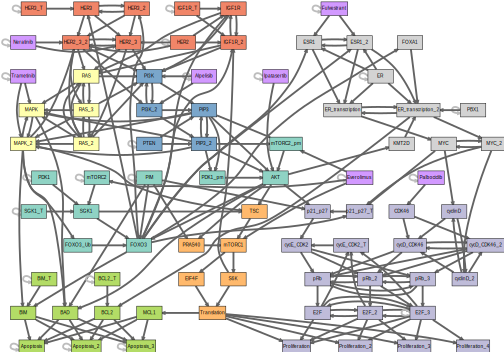

'BreastCancer-SG.pdf'

In [21]:
pSG = graphviz.Digraph(name='Structural Graph', engine='neato')
pSG.attr('graph', size='7,7', concentrate='false', simplify='false', overlap='true',splines='true',ratio='.7',outputorder="edgesfirst",nodesep='.25',mindist='.20')
pSG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false',margin='.05', color='black', style='filled', fillcolor='#515660', penwidth='1', fontname='Helvetica', fontcolor='black',fontsize='10')
pSG.attr('edge', arrowhead='normal', arrowsize='.5', penwidth='4')

for nid,SGatt in SG.nodes(data=True):
    label = SGatt['label']
    if nid in att:
        pos = att[nid].get('pos', '')
        shape = att[nid].get('shape', 'box')
        fillcolor = colors[att[nid].get('type')]
        #width = ''att[nid].get('width', '0.7')
        pSG.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=fillcolor, )

max_penwidth = 4
for uid,vid,d in SG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    # self loop color
    if uid == vid:
        color = '#bdbdbd'
        uid = uid + ':w'
        vid = vid + ':c'
    else:
        color = '#636363'
    pSG.edge(uid, vid, weight=weight, color=color)
    
display(pSG)
# Export
pSG.render("BreastCancer-IG", cleanup=True)

## Effective Graph

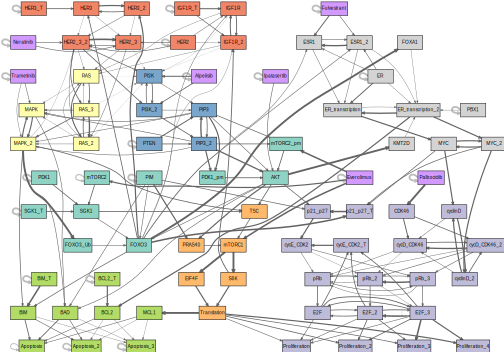

'BreastCancer-EG.pdf'

In [22]:
pEG = graphviz.Digraph(name='Structural Graph', engine='neato')
pEG.attr('graph', size='7,7', concentrate='false', simplify='false', overlap='true',splines='true',ratio='.7',outputorder="edgesfirst",nodesep='.25',mindist='.20')
pEG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false',margin='.05', color='black', style='filled', fillcolor='#515660', penwidth='1', fontname='Helvetica', fontcolor='black',fontsize='10')
pEG.attr('edge', arrowhead='normal', arrowsize='.5', penwidth='4')

max_effoutdegree = max([v for n,v in EG.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
for nid,d in EG.nodes(data=True):
    label = d['label']
    ntype = att[nid].get('type')
    pos = att[nid].get('pos', '')
    shape = att[nid].get('shape')
    fillcolor = colors[ntype]
    pEG.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=fillcolor,)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    if d['weight'] > 0:       
        if uid == vid:
            color = '#bdbdbd'
            uid = uid + ':w'
            vid = vid + ':c'
        else:
            color = '#636363'
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth, color=color)
    else:
        pEG.edge(uid,vid, style='dashed', color='#A90533')
    
display(pEG)
# Export
pEG.render("BreastCancer-EG", cleanup=True)

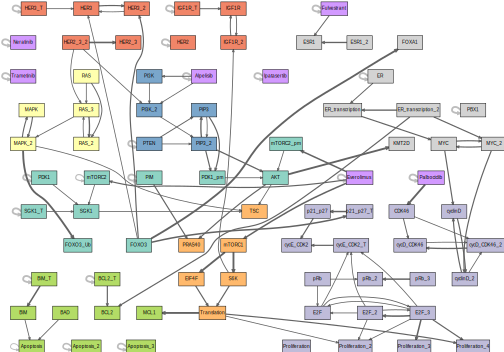

'BreastCancer-EGt0p4.pdf'

In [23]:
pEG = graphviz.Digraph(name='Structural Graph', engine='neato')
pEG.attr('graph', size='7,7', concentrate='false', simplify='false', overlap='true',splines='true',ratio='.7',outputorder="edgesfirst",nodesep='.25',mindist='.20')
pEG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false',margin='.05', color='black', style='filled', fillcolor='#515660', penwidth='1', fontname='Helvetica', fontcolor='black',fontsize='10')
pEG.attr('edge', arrowhead='normal', arrowsize='.5', penwidth='4')

max_effoutdegree = max([v for n,v in EG0p2.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
for nid,d in EG0p4.nodes(data=True):
    label = d['label']
    ntype = att[nid].get('type')
    pos = att[nid].get('pos', '')
    shape = att[nid].get('shape')
    fillcolor = colors[ntype]
    pEG.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=fillcolor,)

max_penwidth = 4
for uid,vid,d in EG0p4.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    if d['weight'] > 0.4:       
        if uid == vid:
            color = '#bdbdbd'
            uid = uid + ':w'
            vid = vid + ':c'
        else:
            color = '#636363'
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth, color=color)
    else:
        pEG.edge(uid,vid, style='dashed', color='#A90533')
    
display(pEG)
# Export
pEG.render("BreastCancer-EGt0p4", cleanup=True)

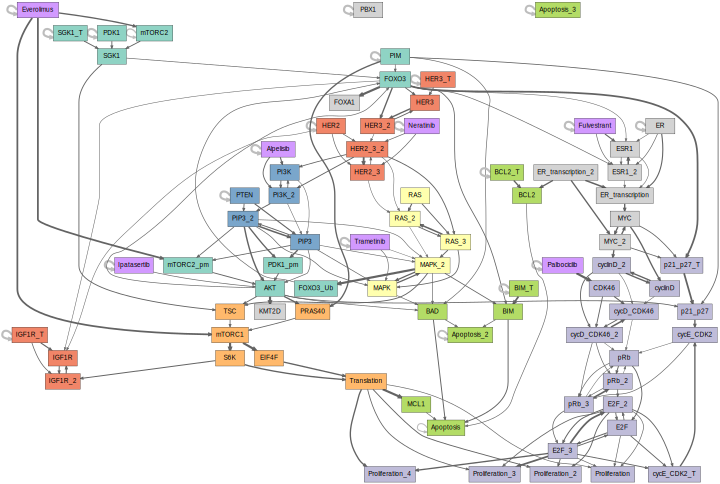

'BreastCancer-EGg0p2-dotlayout.pdf'

In [22]:
pEG = graphviz.Digraph(name='Structural Graph', engine='dot')
pEG.attr('graph', size='10,10', concentrate='false', simplify='false', overlap='false',splines='true',ratio='compress',outputorder="edgesfirst",nodesep='.25',ranksep='.20')
pEG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false', color='black', style='filled', fillcolor='#515660', penwidth='0.5', fontname='Helvetica', fontcolor='black',fontsize='12')
pEG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='3')

max_effoutdegree = max([v for n,v in EG.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
# ColorBar
interval = np.linspace(0.0, 0.70, 256)
cmap = LinearSegmentedColormap.from_list('custom', ['white','#d62728'])
#norm = mpl.colors.Normalize(vmin=0, vmax=1)
norm = mpl.colors.Normalize(vmin=1, vmax=max_effoutdegree)
#
colornodes = ['Apoptosis', 'Apoptosis_2', 'Apoptosis_3', 'Proliferation', 'Proliferation_2', 'Proliferation_3', 'Proliferation_4']
#
for nid,d in EG.nodes(data=True):
    label = d['label']
    ntype = att[nid].get('type')
    pos = ''#att[nid].get('pos', '')
    #width = '{:.2f}'.format( normalize(d['effective_connectivity'], (min_effconn,max_effconn),(0.50,0.80) ) )
    #att[nid]['width'] = width
    shape = att[nid].get('shape')
    #width = att[nid].get('width','0.9')
    # fillcolor
    #if (ntype in ['drugs']) or (label in colornodes):
    fillcolor = colors[ntype]
    #else:
    #    rgb = cmap(norm(EG.out_degree(nid)))
    #    hex = mpl.colors.rgb2hex(rgb)
    #    fillcolor = hex
    pEG.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=fillcolor)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    if d['weight'] >= 0.2:
        if uid == vid:
            color = '#bdbdbd'
            uid = uid + ':w'
            vid = vid + ':c'
        else:
            color = '#636363'
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth, color=color)
    else:
        pass
        #pEG.edge(uid,vid, style='dashed', color='#A90533')
 
# Export
display(pEG)
pEG.render("BreastCancer-EGt0p2-dotlayout", cleanup=True)


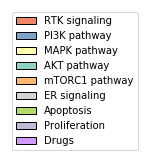

In [185]:
# Legend
from matplotlib.legend import Legend
from matplotlib.patches import Patch

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.4,2.7))

labels = [
    'RTK signaling',
    'PI3K pathway',
    'MAPK pathway',
    'AKT pathway',
    'mTORC1 pathway',
    'ER signaling',
    'Apoptosis',
    'Proliferation',
    'Drugs']

handles = []
for label in labels:
    facecolor = colors[label]
    patch = Patch(facecolor=facecolor, edgecolor='black', label=label)
    handles.append(patch)

leg = ax.legend(handles=handles, labels=labels, loc='upper left')
plt.axis('off')

#plt.subplots_adjust(left=0.09, right=0.98, bottom=0.05, top=0.99, wspace=0.30, hspace=0.0)
plt.savefig("legend.pdf", bbox_inches='tight')
plt.show()